# Esscher Method Demo

This notebook demonstrates the end-to-end calibration workflow implemented in this repository:

1. Load issuer equity time series and debt levels from CSV files.
2. Calibrate physical (P-measure) model parameters on equity log-returns via moment matching.
3. Solve the Esscher equation to obtain `p_star` and update risk-neutral (Q-measure) parameters.
4. Infer daily asset values by inverting the Lewis Fourier pricer (equity as a call on the asset).
5. Re-calibrate physical parameters on inferred asset log-returns and iterate until convergence.
6. Compute distance-to-default and default probability under the physical measure.

The demo uses the datasets shipped in `data/`:
- `data_issuers_2019-2020_market.csv`
- `data_issuers_2020_debt.csv`


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

try:
    from esscher_method.calibrator.calibrator import Calibrator
    from esscher_method.calibrator.data_calibration import CalibrationData, CalibrationConfig
except Exception as exc:
    raise ImportError("Failed to import the calibrator package. Ensure the repository is on PYTHONPATH.") from exc

try:
    from esscher_method.model.model import Merton, VarianceGamma, BilateralGamma
except Exception:
    raise ImportError("Failed to import models.")
try:
    from esscher_method.model.policies import BilateralGammaPolicy, VarianceGammaPolicy
except Exception as exc:
    raise ImportError("Failed to import model policies.") from exc

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 20)


# 1) Load datasets

The market file contains a time series per issuer (one column per ticker).
The debt file contains one row with the gross debt level per issuer.


In [2]:
repo_root = Path.cwd()
data_dir = repo_root /  "data"

market_csv = data_dir / "data_issuers_2019-2020_market.csv"
debt_csv = data_dir / "data_issuers_2020_debt.csv"

if not market_csv.exists():
    raise FileNotFoundError(f"Missing market CSV: {market_csv}")
if not debt_csv.exists():
    raise FileNotFoundError(f"Missing debt CSV: {debt_csv}")

market_df = pd.read_csv(market_csv)
debt_df = pd.read_csv(debt_csv)

market_df["Dates"] = pd.to_datetime(market_df["Dates"], dayfirst=True, errors="coerce")
market_df = market_df.dropna(subset=["Dates"]).set_index("Dates").sort_index()

# Debt file is typically a single-row table, keep it as a 1-row DataFrame
debt_df = debt_df.copy()

print("Market shape:", market_df.shape)
print("Debt shape  :", debt_df.shape)
print("Date range  :", market_df.index.min().date(), "->", market_df.index.max().date())


Market shape: (466, 4)
Debt shape  : (1, 4)
Date range  : 2019-01-01 -> 2020-10-13


In [3]:
# Inspect available tickers
tickers = [c for c in market_df.columns if c in set(debt_df.columns)]
print("Num tickers with both market and debt:", len(tickers))
print("Sample tickers:", tickers[:10])


Num tickers with both market and debt: 4
Sample tickers: ['CRH LN', 'FGR FP', 'DG FP', 'EO FP']


In [4]:
MODEL_NAMES = ["Merton", "VarianceGamma", "BilateralGamma"]

# Global demo knobs
TIME_START = "2019-10-25"
TIME_END = "2020-10-13"
MATURITY = 1.0
UPPER_BOUND = 1e3
SINGLE_CALIBRATION= True

In [5]:


def load_data_for_ticker(
    *,
    ticker: str,
    market_df: pd.DataFrame,
    debt_df: pd.DataFrame,
    time_start: str,
    time_end: str,
    maturity: float,
) -> CalibrationData:
    """
    Build CalibrationData for a given ticker by slicing the market series and reading its debt level.

    Used in:
      - the single-demo run (one ticker, one model)
      - the batch run (all tickers, all models)
    """
    if ticker not in market_df.columns:
        raise KeyError(f"Ticker not found in market_df columns: {ticker}")
    if ticker not in debt_df.columns:
        raise KeyError(f"Ticker not found in debt_df columns: {ticker}")

    equity_values = market_df.loc[time_start:time_end, ticker].dropna().astype(float)
    if equity_values.size < 5:
        raise ValueError(
            f"Not enough equity observations for ticker={ticker} in [{time_start}, {time_end}]. "
            f"Got {equity_values.size}."
        )

    debt_value = float(debt_df.loc[0, ticker])

    return CalibrationData(
        equity_values=equity_values,
        debt=debt_value,
        maturity=float(maturity)    )


def build_model(model_name: str, *, upper_bound: float):
    """
    Factory used by both single-demo and batch runs.
    """
    model_name = str(model_name)

    if model_name == "Merton":
        return Merton()

    if model_name == "BilateralGamma":
        policy = BilateralGammaPolicy(upper_bound=float(upper_bound))
        return BilateralGamma(policy=policy)

    if model_name == "VarianceGamma":
        policy = VarianceGammaPolicy(upper_bound=float(upper_bound))
        return VarianceGamma(policy=policy)

    raise ValueError(f"Unknown model_name: {model_name}")


def rows_to_model_table(rows: list[dict]) -> pd.DataFrame:
    """
    Convert rows for a single model into a readable table:
      - expands params into param.* columns
      - drops all-NaN columns (within the model)
      - orders metadata first, then parameters
    """
    if not rows:
        return pd.DataFrame()

    base_cols = [
        "ticker",
        "model",
        "status",
        "equity_obs",
        "debt",
        "iterations",
        "p_star",
        "dd",
        "pd_pct",
        "final_asset",
        "final_asset_residual",
        "error",
    ]

    base_df = pd.DataFrame([{k: r.get(k, np.nan) for k in base_cols} for r in rows])
    params_df = pd.json_normalize([r.get("params", {}) for r in rows]).add_prefix("param.")
    df = pd.concat([base_df, params_df], axis=1)

    df = df.dropna(axis=1, how="all")

    param_cols = sorted([c for c in df.columns if c.startswith("param.")])
    other_cols = [c for c in df.columns if not c.startswith("param.")]
    return df[other_cols + param_cols]



# 2) Calibration of a single case [ticker + model]



### 2.1) Choose a calibration case

Choose:
- a ticker (column name as present in the CSV files)
- a model: `Merton`, `VarianceGamma`, or `BilateralGamma`
- a time window

In [6]:
if SINGLE_CALIBRATION:
    # Single-case demo selection
    TICKER = tickers[0] if tickers else None
    MODEL_NAME = "BilateralGamma"  # "Merton", "VarianceGamma", "BilateralGamma"

    if TICKER is None:
        raise RuntimeError("No compatible tickers found between market and debt CSV columns.")

    print("Selected ticker:", TICKER)
    print("Selected model :", MODEL_NAME)
    print("Time window    :", TIME_START, "->", TIME_END)
    data = load_data_for_ticker(
        ticker=TICKER,
        market_df=market_df,
        debt_df=debt_df,
        time_start=TIME_START,
        time_end=TIME_END,
        maturity=MATURITY,
    )

    print("Observations:", data.num_observations)
    print("Debt:", data.debt)




model = build_model(MODEL_NAME, upper_bound=UPPER_BOUND)

print("Model:", type(model).__name__)
print("Calibrated parameter names:", getattr(model, "parameter_names", None))
print("Bounds:", getattr(model, "bounds", None))



Selected ticker: CRH LN
Selected model : BilateralGamma
Time window    : 2019-10-25 -> 2020-10-13
Observations: 253
Debt: 10525.0
Model: BilateralGamma
Calibrated parameter names: ('alpha_P', 'lambda_P', 'alpha_M', 'lambda_M')
Bounds: [(0.01, 1000.0), (1.01, 1000.0), (0.01, 1000.0), (0.01, 1000.0)]


### 2.2) Configure and run calibration

Note:  `use_parallel=False` in `CalibrationConfig` is recommended to keep behavior predictable across platforms.

In [7]:
if SINGLE_CALIBRATION:
    config = CalibrationConfig(
        verbose=2,
        de_seed=12345,
        minimization_diff_evolution=True,
        use_parallel=True
    )

    cal = Calibrator(model=model, data=data, config=config)
    # Run the full iterative calibration workflow
    cal.calibration()

    # Keep convention update for downstream reporting (VG adds sigma/theta/nu fields)
    cal.model.parameters_convention_update()

    print("\n\n\nIterations:", cal.get_number_iteration())
    print("p_star:", getattr(cal, "p_star", None))
    print("Distance to default:", cal.distance_to_default)
    print("Default probability (%):", cal.default_probability_computation())
    print("Final parameters:", cal.model.parameters)
    print("Final residuals:", cal.final_residuals())


10:14:03 - Calibrator - INFO - STEP 1 - historical_values_init


10:14:03 - Calibrator - INFO - STEP 4 - physical parameters: {'alpha_P': 134.0597988193997, 'lambda_P': 37.183150509541484, 'alpha_M': 96.54002855474756, 'lambda_M': 27.06394029355006}
10:14:03 - Calibrator - INFO - STEP 4 - sample cumulants   : {'mean': 0.0001519124563775681, 'variance': 0.0009078018097392842, 'skewness': -1.795512731644238e-05, 'fourth_cumulant': 5.95423991099928e-06}
10:14:03 - Calibrator - INFO - STEP 4 - residuals (%)      : [0.00000000e+00 3.58294782e-13 1.69829963e-13 8.53542645e-14]



10:14:03 - Calibrator - INFO - STEP 2 - p_star (bounded solver) = -0.6661927180763156

10:14:03 - Calibrator - INFO - ITERATION 1

10:14:03 - Calibrator - INFO - STEP 2 - risk_neutral_update
10:14:03 - Calibrator - INFO - STEP 2 - p_star (bounded solver) = -0.6661927180763156

10:14:03 - Calibrator - INFO - STEP 3 - asset_log_returns_computation
10:14:03 - Calibrator - INFO - STEP 3 - asset_log_returns_computation |

### 2.3) Sanity-Check: visualize equity vs inferred asset

Equity is treated as a call option on the asset with strike equal to debt.
The inferred asset series is the sequence of implied spots that reproduces the observed equity prices under risk-neutral measure.


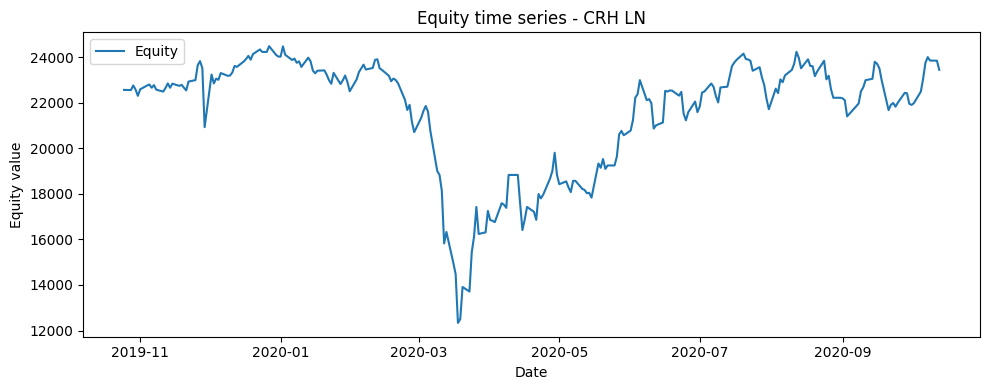

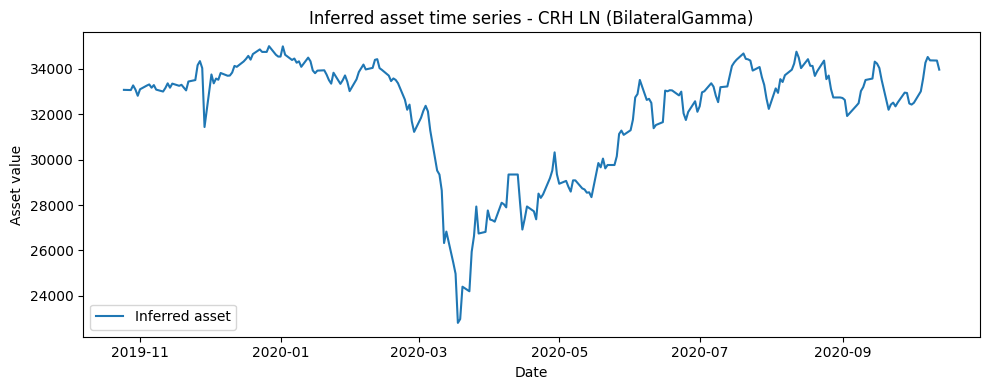

In [8]:
if SINGLE_CALIBRATION:
    asset_values = np.asarray(cal.asset_values, dtype=float).reshape(-1)
    asset_index = data.equity_values.index  # one asset value per equity observation

    fig = plt.figure(figsize=(10, 4))
    plt.plot(data.equity_values.index, data.equity_values.values, label="Equity")
    plt.title(f"Equity time series - {TICKER}")
    plt.xlabel("Date")
    plt.ylabel("Equity value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 4))
    plt.plot(asset_index, asset_values, label="Inferred asset")
    plt.title(f"Inferred asset time series - {TICKER} ({MODEL_NAME})")
    plt.xlabel("Date")
    plt.ylabel("Asset value")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 3) Run all available models for all available tickers


In [9]:
def run_single_calibration(ticker: str, model_name: str) -> dict:
    """
    Run a full calibration for one (ticker, model) pair and return a summary row.

    Parallelization:
      - CalibrationConfig.use_parallel is not overridden -> defaults to True.
    """
    data = load_data_for_ticker(
        ticker=ticker,
        market_df=market_df,
        debt_df=debt_df,
        time_start=TIME_START,
        time_end=TIME_END,
        maturity=MATURITY,
    )

    model = build_model(model_name, upper_bound=UPPER_BOUND)

    cfg = CalibrationConfig(
        max_iterations=20,
        verbose=0,
        minimization_diff_evolution=True,
        de_seed=12345,
    )

    cal = Calibrator(model=model, data=data, config=cfg)
    cal.calibration()

    # Keep convention fields (e.g. VG sigma/theta/nu) for reporting
    cal.model.parameters_convention_update()

    return {
        "ticker": ticker,
        "model": model_name,
        "status": "ok",
        "equity_obs": int(data.num_observations),
        "debt": float(data.debt),
        "iterations": int(cal.get_number_iteration()),
        "p_star": float(getattr(cal, "p_star", np.nan)),
        "dd": float(getattr(cal, "distance_to_default", np.nan)),
        "pd_pct": float(cal.default_probability_computation()),
        "final_asset": float(cal.get_final_asset()),
        "final_asset_residual": float(getattr(cal, "final_asset_residual", np.nan)),
        "error": "N/A",
        "params": dict(cal.model.parameters),
    }


# Run batch: all tickers, all models
rows_by_model: dict[str, list[dict]] = {name: [] for name in MODEL_NAMES}

for ticker in tickers:
    for model_name in MODEL_NAMES:
        print(f"ticker = {ticker} | model_name = {model_name}")
        try:
            row = run_single_calibration(ticker=ticker, model_name=model_name)
        except Exception as exc:
            # Keep a row even on failure
            row = {
                "ticker": ticker,
                "model": model_name,
                "status": "error",
                "equity_obs": np.nan,
                "debt": np.nan,
                "iterations": np.nan,
                "p_star": np.nan,
                "dd": np.nan,
                "pd_pct": np.nan,
                "final_asset": np.nan,
                "final_asset_residual": np.nan,
                "error": f"{type(exc).__name__}: {exc}",
                "params": {},
            }

        rows_by_model[model_name].append(row)




ticker = CRH LN | model_name = Merton
ticker = CRH LN | model_name = VarianceGamma
ticker = CRH LN | model_name = BilateralGamma
ticker = FGR FP | model_name = Merton
ticker = FGR FP | model_name = VarianceGamma
ticker = FGR FP | model_name = BilateralGamma
ticker = DG FP | model_name = Merton
ticker = DG FP | model_name = VarianceGamma
ticker = DG FP | model_name = BilateralGamma
ticker = EO FP | model_name = Merton
ticker = EO FP | model_name = VarianceGamma
ticker = EO FP | model_name = BilateralGamma


In [10]:
# Display one table per model 
tables_by_model: dict[str, pd.DataFrame] = {}

for model_name in MODEL_NAMES:
    df_model = rows_to_model_table(rows_by_model.get(model_name, []))
    tables_by_model[model_name] = df_model
    print(f"\n=== Results: {model_name} ===")
    display(df_model)



=== Results: Merton ===


,ticker,model,status,equity_obs,debt,iterations,p_star,dd,pd_pct,final_asset,final_asset_residual,error,param.mu,param.sigma
0,CRH LN,Merton,ok,253,10525.0,6,-0.788724,1.171578,0.003875,33965.043818,-2.910383e-11,N/A,0.026536,0.303165
1,FGR FP,Merton,ok,253,15669.0,8,4.061023,0.371909,3.050092,22727.905481,5.987172e-06,N/A,-0.097704,0.146361
2,DG FP,Merton,ok,253,32397.0,6,1.733264,0.867570,1.007566,77141.059383,2.166489e-06,N/A,-0.189945,0.291638
3,EO FP,Merton,ok,253,4837.9,8,0.755741,0.728373,1.133240,10022.715325,7.142041e-06,N/A,-0.096522,0.277245



=== Results: VarianceGamma ===


,ticker,model,status,equity_obs,debt,iterations,p_star,dd,pd_pct,final_asset,final_asset_residual,error,param.alpha,param.lambda_M,param.lambda_P,param.nu,param.sigma,param.theta
0,CRH LN,VarianceGamma,ok,253,10525.0,7,-0.788796,1.171578,0.004601,33965.025362,-3.274181e-11,N/A,127.974583,53.060094,52.482502,0.007814,0.303170,0.026544
1,FGR FP,VarianceGamma,ok,253,15669.0,11,4.079994,0.371904,3.101388,22727.793350,5.730143e-06,N/A,122.315144,102.598443,111.758431,0.008176,0.146064,-0.097713
2,DG FP,VarianceGamma,ok,253,32397.0,8,1.742092,0.867565,1.058059,77140.657115,2.164801e-06,N/A,110.931718,48.981182,53.465365,0.009015,0.291066,-0.189949
3,EO FP,VarianceGamma,ok,253,4837.9,11,0.756241,0.728368,1.145944,10022.665787,7.137392e-06,N/A,316.202666,89.475955,91.988438,0.003163,0.277190,-0.096523



=== Results: BilateralGamma ===


,ticker,model,status,equity_obs,debt,iterations,p_star,dd,pd_pct,final_asset,final_asset_residual,error,param.alpha_M,param.alpha_P,param.lambda_M,param.lambda_P
0,CRH LN,BilateralGamma,ok,253,10525.0,8,-0.788055,1.171577,0.006432,33964.980601,-6.912160e-11,N/A,117.988789,162.757283,47.252343,64.494736
1,FGR FP,BilateralGamma,ok,253,15669.0,11,4.128402,0.371901,3.174467,22727.719437,5.379065e-06,N/A,118.061748,149.990569,95.910583,132.356921
2,DG FP,BilateralGamma,ok,253,32397.0,8,1.780776,0.867558,1.148340,77140.176813,2.098699e-06,N/A,109.523282,168.840981,44.713705,74.725835
3,EO FP,BilateralGamma,ok,253,4837.9,11,0.761854,0.728353,1.196821,10022.508864,7.240560e-06,N/A,298.261383,416.903642,80.702732,115.829577
